### Single pipeline to find velocity law 

In [72]:
import sys
import numpy as np

sys.path.append('..')

from seismicpro.src import seismic_plot, FieldIndex, SeismicDataset, CustomIndex, TraceIndex
from seismicpro.src.plot_utils import semblance_plot
from seismicpro.src.seismic_metrics import PickingMetrics, SemblanceMetrics, MetricsMap

from seismicpro.batchflow import B, V, I
from seismicpro.batchflow.models.torch import UNet

import warnings
warnings.filterwarnings('ignore')

In [2]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


Loading the data and CDP index creation

In [3]:
supergather_path = '/data/H2_PAL/SEMB/H2_PAL_CDP_10x10_SG7.sgy'
part_path = '/data/H2_PAL/SEMB/H2_PAL_CDP.sgy'
full_path = '/data/H2_PAL/SEMB/H2_PAL_SR-lines.sgy'

path_to_model = '../models/trained_model.dill'

config = {
    'build': False,
    'device': 'gpu:0',
    'load/path':  path_to_model
}

supergather_index = FieldIndex(name='raw', extra_headers=['offset', 'CDP_X', 'CDP_Y', 'SourceX', 'SourceY'], path=supergather_path)
supergather_index_cdp = CustomIndex(supergather_index, index_name='CDP')
supergather_dataset = SeismicDataset(supergather_index_cdp)

### Supergathers
Predict for supergathers and construct quality map for picking prediction

In [5]:
supergather_pipeline = (
    supergather_dataset.p
    .add_namespace(PickingMetrics)
    .init_model('static', UNet, 'picking_model', config=config)
    .init_variable('metrics')
    .init_variable('velocity', [])
    .load(components='raw', fmt='segy')
    .load(fmt='index', components='offset', src='offset')
    .sort_traces(src='raw', dst='raw', sort_by='offset')
    .standardize(src='raw', dst='std')
    .apply_transform_all(src='std', dst='std', func=lambda x: np.concatenate(x)[: 1350 , np.newaxis, : 1800])
    .add_components(components='picking')
    .predict_model('picking_model', B('std'), fetches='predictions',
                   save_to=B('picking', mode='a'))
    .mask_to_pick(src='picking', dst='picking', labels=False)
    .apply_transform_all(src='picking', dst='picking', func=lambda x: x[np.newaxis] * 2) ### переписать!!!!
    .add_muting(src='raw', dst='raw', picking='picking',
                interp_type='regression', indent=500)
    .calculate_semblance(src='raw', dst='raw_semblance', velocities=[1300, 5500],
                         velocities_length=140, window=25)
    .find_velocity_model(src='raw_semblance', dst='velocity_points', v_0=1600, v_n=3500, n_iter=300)
    .update(V('velocity', mode='a'), [B('index').indices[0], B('velocity_points')])
    .velocity(B(), src_picking='picking', dst='diff')
    .get_coords_fm_supergather(src=['CDP_X', 'CDP_Y'], dst='coords')
    .gather_metrics(MetricsMap, metrics=B('diff'),
                    coords=B('coords'),
                    save_to=V('metrics', mode='a'))
    .run_later(1, n_epochs=1, drop_last=False, shuffle=False, bar=True)
)

In [6]:
batch = supergather_pipeline.next_batch(1)

In [8]:
supergather_pipeline.run(1, n_epochs=1, drop_last=False, shuffle=False, bar=True)

100%|██████████| 43/43 [03:40<00:00,  5.12s/it]


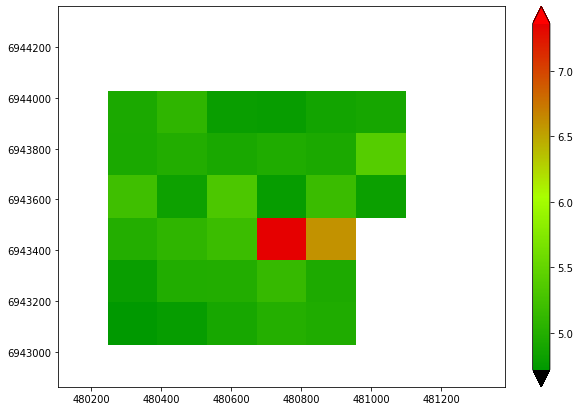

Mean value of metrics: 5.1


In [15]:
metrics = supergather_pipeline.v('metrics')
mean_metrics = metrics.evaluate('map', bin_size=250, figsize=(10, 7), save_dir=None, pad=True)
print('Mean value of metrics: {:.3}'.format(mean_metrics))

### Map for CSP
Construct quality map for picking model

In [4]:
full_index = FieldIndex(name='raw', extra_headers=['offset', 'CDP_X', 'CDP_Y', 'SourceX', 'SourceY'], path=full_path)
full_dataset = SeismicDataset(full_index)

In [5]:
full_pipeline = (
    full_dataset.p
    .add_namespace(PickingMetrics)
    .init_model('static', UNet, 'picking_model', config=config)
    .init_variable('metrics')
    .init_variable('velocity', [])
    .load(components='raw', fmt='segy')
    .load(fmt='index', components='offset', src='offset')
    .sort_traces(src='raw', dst='raw', sort_by='offset')
    .standardize(src='raw', dst='std')
    .apply_transform_all(src='std', dst='std', func=lambda x: np.concatenate(x)[: 1800, np.newaxis, : 1500])
    .add_components(components='picking')
    .predict_model('picking_model', B('std'), fetches='predictions',
                   save_to=B('picking', mode='a'))
    .mask_to_pick(src='picking', dst='picking', labels=False)
    .apply_transform_all(src='picking', dst='picking', func=lambda x: x[np.newaxis] * 2) ### переписать!!!!
    .add_muting(src='raw', dst='raw', picking='picking',
                interp_type='regression', indent=500)
    .calculate_semblance(src='raw', dst='raw_semblance', velocities=[1300, 5500],
                         velocities_length=140, window=25)
    .find_velocity_model(src='raw_semblance', dst='velocity_points', v_0=1600, v_n=3500, n_iter=300)
    .update(V('velocity', mode='a'), [B('velocity_points')])
    .velocity(B(), src_picking='picking', dst='diff')
    .gather_metrics(MetricsMap, metrics=B('diff'),
                    coords=B('index').get_df()[['SourceX', 'SourceY']].drop_duplicates().values,
                    save_to=V('metrics', mode='a'))
    .run_later(1, n_epochs=1, drop_last=False, shuffle=False, bar=True)
)

In [6]:
full_pipeline.run()

100%|██████████| 3421/3421 [5:18:31<00:00,  5.59s/it]  


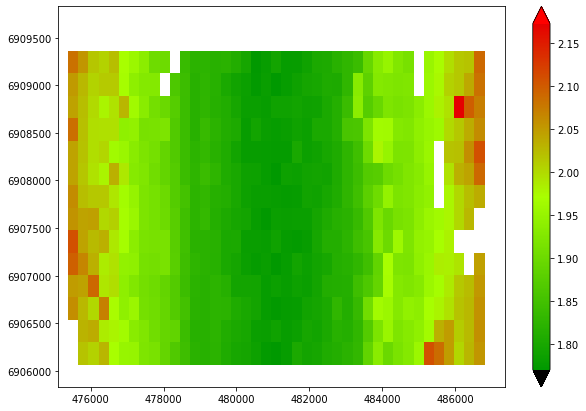

Mean value of metrics: 1.89


In [13]:
metrics = full_pipeline.v('metrics')
mean_metrics = metrics.evaluate('map', bin_size=300, figsize=(10, 7), save_dir='./huge_sources_all.png', pad=True)
print('Mean value of metrics: {:.3}'.format(mean_metrics))

In [61]:
vel_list = np.array(full_pipeline.v('velocity'))
vel_list = np.concatenate(np.concatenate(np.concatenate(vel_list))).reshape(-1, 2250, 2)

mean_velocity = np.mean(vel_list, axis=0)

Calculate the quality of found speed law and plot the quality map.

In [102]:
from seismicpro.batchflow import inbatch_parallel
class VelMetrics:
    @staticmethod
    @inbatch_parallel(init="_init_component", target="threads")
    def calculate_vel_diff(batch, index, dst, mean_vel, current_vel):
        pos = batch.get_pos(None, None, index)
        getattr(batch, dst)[pos] = np.mean(np.abs(mean_vel[:, 1] - current_vel[:, 1]))
        return batch

In [107]:
vel_metrics_ppl = (
    full_dataset.p
    .add_namespace(VelMetrics)
    .init_variable('metrics')
    .init_variable('vel_list', vel_list)
    .calculate_vel_diff(B(), dst='vel_diff', 
                        mean_vel=mean_velocity, current_vel=V('vel_list')[I()-1])
    .gather_metrics(MetricsMap, metrics=B('vel_diff'),
                    coords=B('index').get_df()[['SourceX', 'SourceY']].drop_duplicates().values,
                    save_to=V('metrics', mode='a'))
    .run_later(1, n_epochs=1, drop_last=False, shuffle=False, bar=False)
)

In [108]:
vel_metrics_ppl.run()

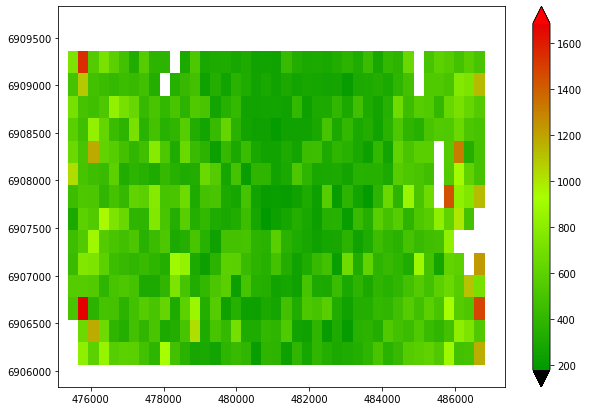

Mean value of metrics: 4.63e+02


In [109]:
vel_metrics = vel_metrics_ppl.v('metrics')
mean_metrics = vel_metrics.evaluate('map', bin_size=300, figsize=(10, 7), save_dir='./vel_metrics.png', pad=True)
print('Mean value of metrics: {:.3}'.format(mean_metrics))